In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
# #         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install dataset
!pip uninstall fsspec --yes

! pip install transformers datasets
#! sudo apt install tesseract-ocr
! pip install pytesseract

import numpy as np 
import pandas as pd

import requests, zipfile, io

from sklearn.utils import shuffle

from datasets import Dataset
import os



Found existing installation: fsspec 2022.3.0
Uninstalling fsspec-2022.3.0:
  Successfully uninstalled fsspec-2022.3.0
  Using cached fsspec-2022.3.0-py3-none-any.whl (136 kB)


/home/msiwecki/.conda/envs/Dokumentskan/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-04-15 06:11:00.631964: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-15 06:11:00.632041: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


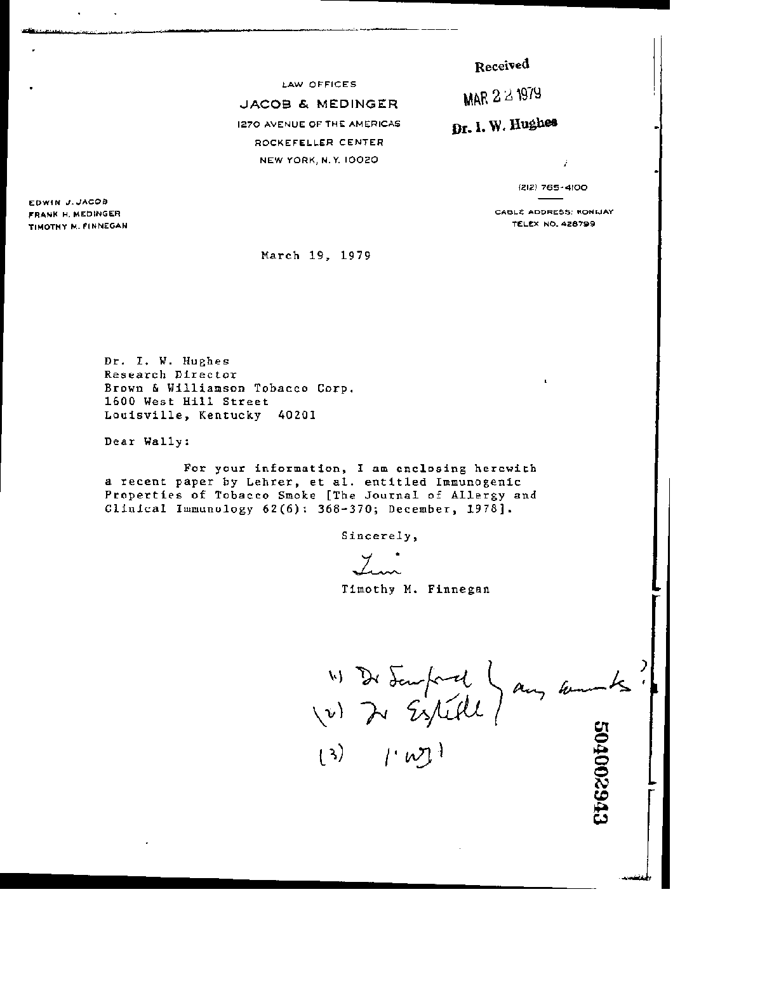

In [3]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open("test/letter/0000000700.tif")
image = image.convert("RGB")
image

In [7]:
import pytesseract
import numpy as np

ocr_df = pytesseract.image_to_data(image, output_type='data.frame',config="-c tessedit_char_whitelist=0123456789abcdefghijklmnopqrstuvwxyz --psm 6")
ocr_df = ocr_df.dropna().reset_index(drop=True)
float_cols = ocr_df.select_dtypes('float').columns
ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
words = ' '.join([word for word in ocr_df.text if str(word) != 'nan'])
words

'S088 | . cam DFICEE 8 NEDINGER mea eS GRO AMENUCUNOEDAEMES yey HH) LUBE ROCKEFELLER CENTER NEW YORK, My. 10020 : Karch [3] (79 br. T. W. Wughes Reseach Director . Brown § Williamson (obacca 1500 West Hill Stecet Locteville, Kentucky 40201 Deer watty: For your information, I an enclosing herovich @ cEcenu paper P| benrer] ev gl) entitled Properties Of Tobacee Smoke [The Journal of Allergy and CLindeal Tusunology 62(6): 366-370; December, 1976]. Sincerely, Timothy M. Finnegan hd a ap a) kal 7 Ee oot 8 A R f'

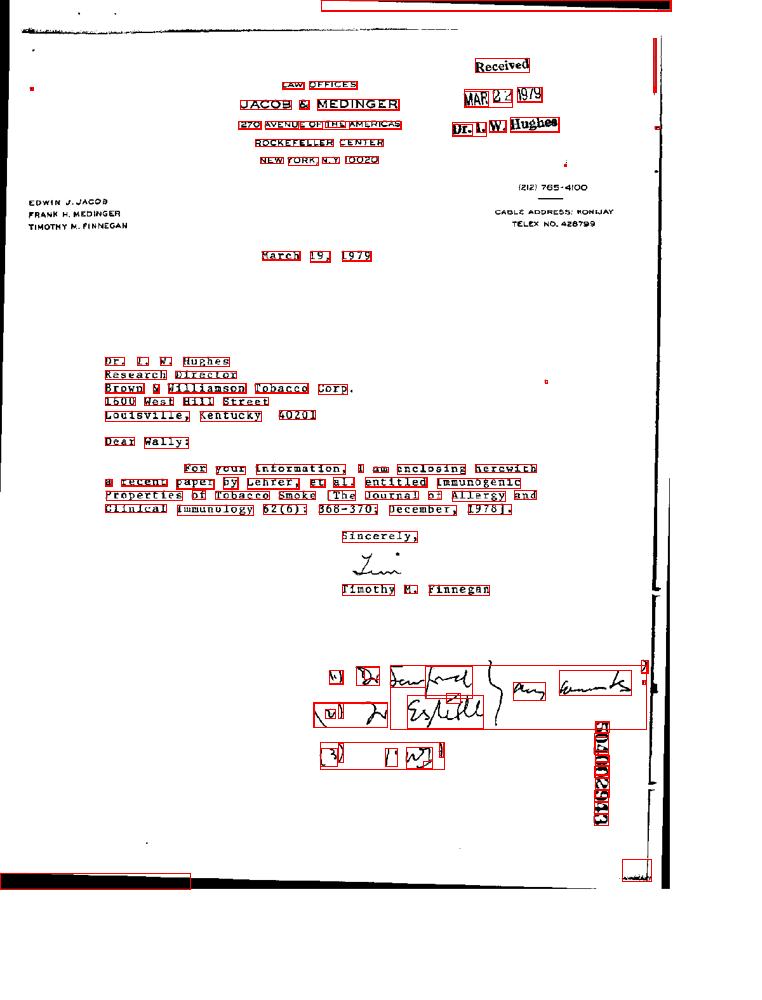

In [8]:
coordinates = ocr_df[['left', 'top', 'width', 'height']]
actual_boxes = []
for idx, row in coordinates.iterrows():
    x, y, w, h = tuple(row) # the row comes in (left, top, width, height) format
    actual_box = [x, y, x+w, y+h] # we turn it into (left, top, left+width, top+height) to get the actual box 
    actual_boxes.append(actual_box)

draw = ImageDraw.Draw(image, "RGB")
for box in actual_boxes:
  draw.rectangle(box, outline='red')

image

In [9]:
dataset_path = "test"
labels = [label for label in os.listdir(dataset_path)]
idx2label = {v: k for v, k in enumerate(labels)}
label2idx = {k: v for v, k in enumerate(labels)}
label2idx

{'news_article': 0,
 'form': 1,
 'scientific_publication': 2,
 'specification': 3,
 'scientific_report': 4,
 'letter': 5,
 'budget': 6,
 'questionnaire': 7,
 'resume': 8,
 'file_folder': 9,
 'advertisement': 10,
 'presentation': 11,
 'memo': 12,
 'invoice': 13,
 'handwritten': 14,
 'email': 15}

In [10]:
data=pd.DataFrame()
i=0
for label in os.listdir(dataset_path):
    count=0
    for filename in os.listdir(dataset_path+'/'+label):

        if '.ipynb' not in filename and count<200:
            data.at[i,'image_path']=dataset_path+'/'+label+'/'+filename
            data.at[i,'label']=label
            i=i+1
            count=count+1


data = shuffle(data)

In [11]:
data.head()

,image_path,label
320,test/form/2074196422.tif,form
2194,test/advertisement/tob00603.92.tif,advertisement
2419,test/memo/10009163.tif,memo
2639,test/invoice/2505165345.tif,invoice
2137,test/advertisement/13029859.tif,advertisement


In [12]:
len(data)

3200

In [13]:
data.columns
from transformers import LayoutLMTokenizer
import torch
from datasets import Features, Sequence, ClassLabel, Value, Array2D

In [14]:
X=data[['image_path']]
y=data[['label']]

In [15]:
X

,image_path
320,test/form/2074196422.tif
2194,test/advertisement/tob00603.92.tif
2419,test/memo/10009163.tif
2639,test/invoice/2505165345.tif
2137,test/advertisement/13029859.tif
...,...
1277,test/budget/0000444243.tif
2033,test/advertisement/502657867+-7867.tif
633,test/specification/2031304693.tif
1048,test/letter/1003868542_8543.tif


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4, stratify=y)

X_valid,X_test,y_valid,y_test=train_test_split(X_val, y_val, test_size=0.5, stratify=y_val)

In [17]:
train_data=pd.concat([X_train, y_train], axis=1)
valid_data=pd.concat([X_valid, y_valid], axis=1)
test_data=pd.concat([X_test, y_test], axis=1)

In [18]:
print(len(train_data))
print(len(valid_data))
print(len(test_data))

1920
640
640


In [19]:
train_size=len(train_data)
validation_size=len(valid_data)
test_size=len(test_data)

In [20]:
from datasets import Dataset

def normalize_box(box, width, height):
     return [
         int(1000 * (box[0] / width)),
         int(1000 * (box[1] / height)),
         int(1000 * (box[2] / width)),
         int(1000 * (box[3] / height)),
     ]

def apply_ocr(example):
        # get the image
        image = Image.open(example['image_path'])

        width, height = image.size
        
        # apply ocr to the image 
        ocr_df = pytesseract.image_to_data(image, output_type='data.frame')
        float_cols = ocr_df.select_dtypes('float').columns
        ocr_df = ocr_df.dropna().reset_index(drop=True)
        ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
        ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
        ocr_df = ocr_df.dropna().reset_index(drop=True)

        # get the words and actual (unnormalized) bounding boxes
        #words = [word for word in ocr_df.text if str(word) != 'nan'])
        words = list(ocr_df.text)
        words = [str(w) for w in words]
        coordinates = ocr_df[['left', 'top', 'width', 'height']]
        actual_boxes = []
        for idx, row in coordinates.iterrows():
            x, y, w, h = tuple(row) # the row comes in (left, top, width, height) format
            actual_box = [x, y, x+w, y+h] # we turn it into (left, top, left+width, top+height) to get the actual box 
            actual_boxes.append(actual_box)
        
        # normalize the bounding boxes
        boxes = []
        for box in actual_boxes:
            boxes.append(normalize_box(box, width, height))
        
        # add as extra columns 
        assert len(words) == len(boxes)
        example['words'] = words
        example['bbox'] = boxes
        return example

In [21]:
train_dataset = Dataset.from_pandas(train_data)
updated_train_dataset = train_dataset.map(apply_ocr)

valid_dataset = Dataset.from_pandas(valid_data)
updated_valid_dataset = valid_dataset.map(apply_ocr)

test_dataset = Dataset.from_pandas(test_data)
updated_test_dataset = test_dataset.map(apply_ocr)


updated_train_dataset=updated_train_dataset.remove_columns('__index_level_0__')
updated_valid_dataset=updated_valid_dataset.remove_columns('__index_level_0__')
updated_test_dataset=updated_test_dataset.remove_columns('__index_level_0__')

100%|██████████| 640/640 [22:37<00:00,  2.12s/ex]


In [22]:
#!pip install torch
from transformers import LayoutLMTokenizer
import torch
from datasets import Features, Sequence, ClassLabel, Value, Array2D

tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")

def encode_example(example, max_seq_length=512, pad_token_box=[0, 0, 0, 0]):
  words = example['words']
  normalized_word_boxes = example['bbox']

  assert len(words) == len(normalized_word_boxes)

  token_boxes = []
  for word, box in zip(words, normalized_word_boxes):
      word_tokens = tokenizer.tokenize(word)
      token_boxes.extend([box] * len(word_tokens))
  
  # Truncation of token_boxes
  special_tokens_count = 2 
  if len(token_boxes) > max_seq_length - special_tokens_count:
      token_boxes = token_boxes[: (max_seq_length - special_tokens_count)]
  
  # add bounding boxes of cls + sep tokens
  token_boxes = [[0, 0, 0, 0]] + token_boxes + [[1000, 1000, 1000, 1000]]
  
  encoding = tokenizer(' '.join(words), padding='max_length', truncation=True)
  # Padding of token_boxes up the bounding boxes to the sequence length.
  input_ids = tokenizer(' '.join(words), truncation=True)["input_ids"]
  padding_length = max_seq_length - len(input_ids)
  token_boxes += [pad_token_box] * padding_length
  encoding['bbox'] = token_boxes
  encoding['label'] = label2idx[example['label']]

  assert len(encoding['input_ids']) == max_seq_length
  assert len(encoding['attention_mask']) == max_seq_length
  assert len(encoding['token_type_ids']) == max_seq_length
  assert len(encoding['bbox']) == max_seq_length

  return encoding



features = Features({
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'label': ClassLabel(names=['refuted', 'entailed']),
    'image_path': Value(dtype='string'),
    'words': Sequence(feature=Value(dtype='string')),
})

In [23]:
encoded_train_dataset = updated_train_dataset.map(lambda example: encode_example(example), 
                                      features=features)

encoded_train_dataset.set_format(type='torch', columns=['input_ids', 'bbox', 'attention_mask', 'token_type_ids', 'label'])


encoded_valid_dataset = updated_valid_dataset.map(lambda example: encode_example(example), 
                                      features=features)

encoded_valid_dataset.set_format(type='torch', columns=['input_ids', 'bbox', 'attention_mask', 'token_type_ids', 'label'])

encoded_test_dataset = updated_test_dataset.map(lambda example: encode_example(example), 
                                      features=features)

encoded_test_dataset.set_format(type='torch', columns=['input_ids', 'bbox', 'attention_mask', 'token_type_ids', 'label'])

100%|██████████| 640/640 [00:10<00:00, 59.28ex/s]


In [24]:
#!pip install PyTorch tensors

In [25]:
train_dataloader = torch.utils.data.DataLoader(encoded_train_dataset, batch_size=5, shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(encoded_valid_dataset, batch_size=2, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(encoded_test_dataset, batch_size=1, shuffle=True)

In [26]:
from transformers import LayoutLMForSequenceClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LayoutLMForSequenceClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=len(label2idx))
model.to(device)

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias']
- This IS expected if you are initializing LayoutLMForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForSequenceClassification were not initialized from the model checkpoint 

LayoutLMForSequenceClassification(
  (layoutlm): LayoutLMModel(
    (embeddings): LayoutLMEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 768)
      (y_position_embeddings): Embedding(1024, 768)
      (h_position_embeddings): Embedding(1024, 768)
      (w_position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LayoutLMEncoder(
      (layer): ModuleList(
        (0): LayoutLMLayer(
          (attention): LayoutLMAttention(
            (self): LayoutLMSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
      

In [ ]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 50
t_total = len(train_dataloader) * num_train_epochs # total number of training steps 


for epoch in range(num_train_epochs):
  print("Epoch:", epoch)
  running_loss = 0.0
  correct = 0
  model.train()
  for batch in train_dataloader:
      input_ids = batch["input_ids"].to(device)
      bbox = batch["bbox"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      token_type_ids = batch["token_type_ids"].to(device)
      labels = batch["label"].to(device)

      # forward pass
      outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                      labels=labels)
      loss = outputs.loss

      running_loss += loss.item()
      predictions = outputs.logits.argmax(-1)
      correct += (predictions == labels).float().sum()

      # backward pass to get the gradients 
      loss.backward()

      # update
      optimizer.step()
      optimizer.zero_grad()
      global_step += 1
  
  print("Loss:", running_loss / batch["input_ids"].shape[0])
  accuracy = 100 * correct / train_size
  print("Training accuracy:", accuracy.item())
    
  if epoch%5==0:
    model.eval()

    correct = 0
    for batch in validation_dataloader:
        input_ids = batch["input_ids"].to(device)
        bbox = batch["bbox"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        token_type_ids = batch["token_type_ids"].to(device)
        labels = batch["label"].to(device)
        outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids)
        predictions = outputs.logits.argmax(-1)
        correct += (predictions == labels).float().sum()

    accuracy = 100 * correct / validation_size
    print("Validation accuracy:", accuracy.item())

/home/msiwecki/.conda/envs/Dokumentskan/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch: 0


In [ ]:
model.eval()
labels_output=[]
predictions_output=[]


correct = 0
for batch in test_dataloader:
    input_ids = batch["input_ids"].to(device)
    bbox = batch["bbox"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    token_type_ids = batch["token_type_ids"].to(device)
    labels = batch["label"].to(device)
    outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids)
    predictions = outputs.logits.argmax(-1)
#     print(labels)
#     print(predictions)
    correct += (predictions == labels).float().sum()
#     print(correct)

accuracy = 100 * correct / test_size
print("Testing accuracy:", accuracy.item())